In [1]:
import pandas as pd 
from typing import List, Dict, Any
import numpy as np



In [2]:
exp1 = "../results/ALL_complete_meaningful_2.csv"
exp2 = "../results/ALL_complete_meaningful.csv"
exp3 = "../results/Baseline_20_meaningful.csv"
exp4 = "../results/Baseline_20_random.csv"
exp5 = "../results/SGD_20_random.csv"
exp6 = "../results/SGD_complete_meaningful.csv"

In [35]:
df1 = pd.read_csv(exp1)
df2 = pd.read_csv(exp2)
df3 = pd.read_csv(exp3)
df4 = pd.read_csv(exp4)
df5 = pd.read_csv(exp5)
df6 = pd.read_csv(exp6)

df1['dataset_type'] = 'meaningful'
df2['dataset_type'] = 'meaningful'

df5['dataset_type'] = 'random'
df6['dataset_type'] = 'meaningful'

df_56 = pd.concat([df5, df6], axis=0)

df3['optimizer'] = 'baseline'
df4['optimizer'] = 'baseline'

df3['dataset_type'] = 'meaningful'
df4['dataset_type'] = 'random'

df_34 = pd.concat([df3, df4], axis=0)

df = pd.concat([df_34, df_56], axis=0)

# concat also the df1 and df2 to the others
df = pd.concat([df, df1, df2], axis=0)


In [48]:
def compute_statistics(df: pd.DataFrame, column_name: str = "timesteps", indices: List[int] = [10], agg = "mean"):
    assert column_name in ["timesteps", "times"], "Choises for `column_name`: ['timesteps', 'times']."
    
    column = df[column_name]
    scores = column.apply(lambda x: list(float(i) for i in x.split("_")))

    if agg == "mean":
        scores = [
            scores.apply(lambda x: np.mean(x[:i + 1]))
            for i in indices
        ]
    else:
        scores = [
            scores.apply(lambda x: np.sum(x[:i + 1]))
            for i in indices
        ]
    return [
        (x.mean(), x.std())
        for x in scores
    ]


### Plotting

In [49]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
from utils.metrics import _agg_metric
from utils.constants import COLORS

def _rename(name, rename_dict):
    """
    Rename a metric name based on a provided dictionary.
    Args:
        name (str): Original metric name.
        rename_dict (dict): Dictionary mapping original names to new names.
    Returns:
        str: Renamed metric name.
    """
    return rename_dict.get(name, name) if rename_dict else name


def plot_metrics(
        metrics, 
        fill_between=True, 
        rename=None, 
        xlabel=None,
        ylabel=None,
        title=None,
        figsize=(10, 6),
        integer_xticks=False  # New parameter
):  
    """
    Plot aggregated metrics per layer.
    Args:
        metrics (dict): Dictionary containing metric values for each layer.
        fill_between (bool): Whether to fill the area between mean and std.
        rename (dict): Optional dictionary to rename labels of metrics.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.
        title (str): Title of the plot.
        figsize (tuple): Size of the plot.
        integer_xticks (bool): Whether to force x-axis ticks to be integers.
    """
    agg_metrics = {}
    for metric in metrics:
        agg_metrics[metric] = _agg_metric(metrics, metric)
    fig, ax = plt.subplots(figsize=figsize)

    for i, (metric_name, (mean, std)) in enumerate(agg_metrics.items()):
        x_ticks = range(len(mean))
        
        if fill_between:
            ax.fill_between(x_ticks, mean - std, mean + std, alpha=0.2, color=COLORS[i % len(COLORS)])
        
        ax.plot(mean, label=_rename(metric_name, rename), color=COLORS[i % len(COLORS)], marker='o')

    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend()

    if integer_xticks:
        ax.set_xticks(range(len(mean)))
        ax.set_xticklabels([str(x + 1) for x in x_ticks])

    plt.show()
  

### Experiments 8.1

E8.1 show how the convergence rate change when you change the gradient step-size 



In [50]:
len(df)

340

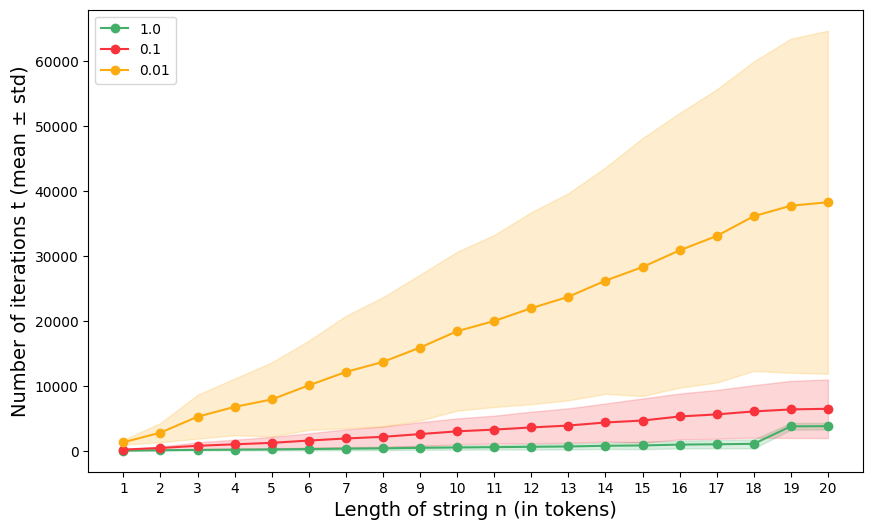

In [53]:
dataset_type = 'meaningful'
optimizer = 'SGD'
layer = 6
learning_rates = df[df['optimizer'] == optimizer]['learning_rate'].unique().tolist()

# filter dataframe based on dataset_type and optimizer 
df_exp_8_1 = df[(df['dataset_type'] == dataset_type) & (df['optimizer'] == optimizer) & (df['layer'] == layer)]
df_exp_8_1.head()

df_exp_8_1_results = {
    x: compute_statistics(df_exp_8_1[df_exp_8_1['learning_rate'] == x], indices=range(20), column_name='timesteps', agg = "sum")
    for x in learning_rates
}

plot_metrics(
    metrics=df_exp_8_1_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
) 

Average accross all the 8 layers 

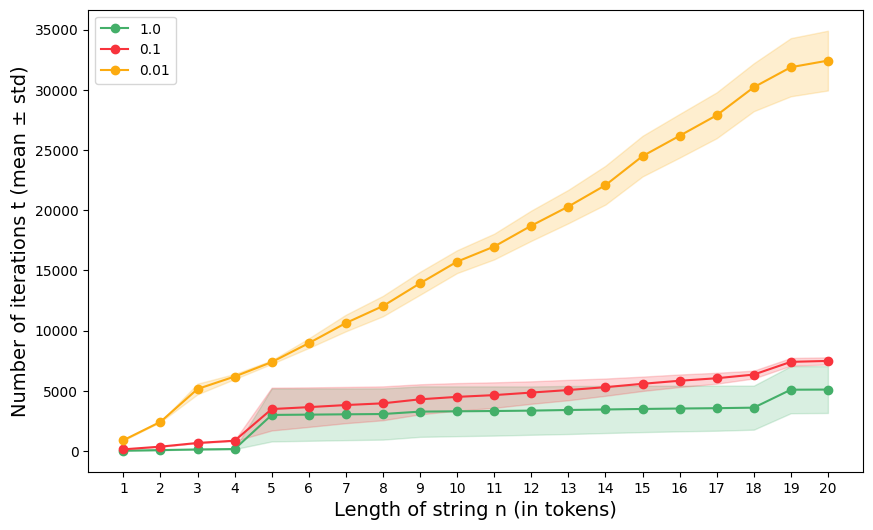

In [55]:
# now compute the same quantities but averaged for all layers from 1 to 8
df_exp_8_1_all_layers = df[(df['dataset_type'] == dataset_type) & (df['optimizer'] == optimizer)]
df_exp_8_1_all_layers_results = {
    x: compute_statistics(df_exp_8_1_all_layers[df_exp_8_1_all_layers['learning_rate'] == x], indices=range(20), column_name='timesteps', agg = "sum")
    for x in learning_rates
}
plot_metrics(
    metrics=df_exp_8_1_all_layers_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
)

We also keep printing this interesting outlier in the last layer hinting something for larger models

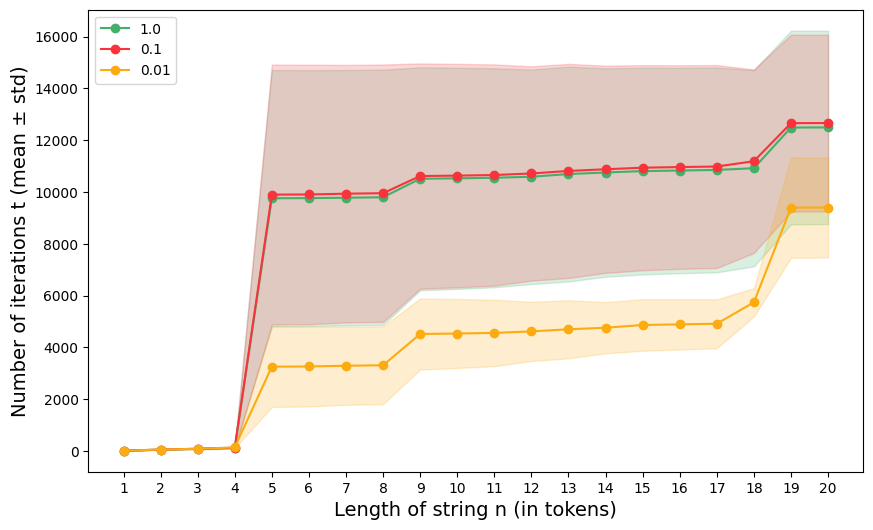

In [56]:
dataset_type = 'meaningful'
optimizer = 'SGD'
layer = 8
learning_rates = df[df['optimizer'] == optimizer]['learning_rate'].unique().tolist()

# filter dataframe based on dataset_type and optimizer 
df_exp_8_1 = df[(df['dataset_type'] == dataset_type) & (df['optimizer'] == optimizer) & (df['layer'] == layer)]
df_exp_8_1.head()

df_exp_8_1_results = {
    x: compute_statistics(df_exp_8_1[df_exp_8_1['learning_rate'] == x], indices=range(20), column_name='timesteps',agg = "sum")
    for x in learning_rates
}

plot_metrics(
    metrics=df_exp_8_1_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
) 

### Experiment 8.2 

E8.2 show how the convergence rate change when you change the first order algorithm 

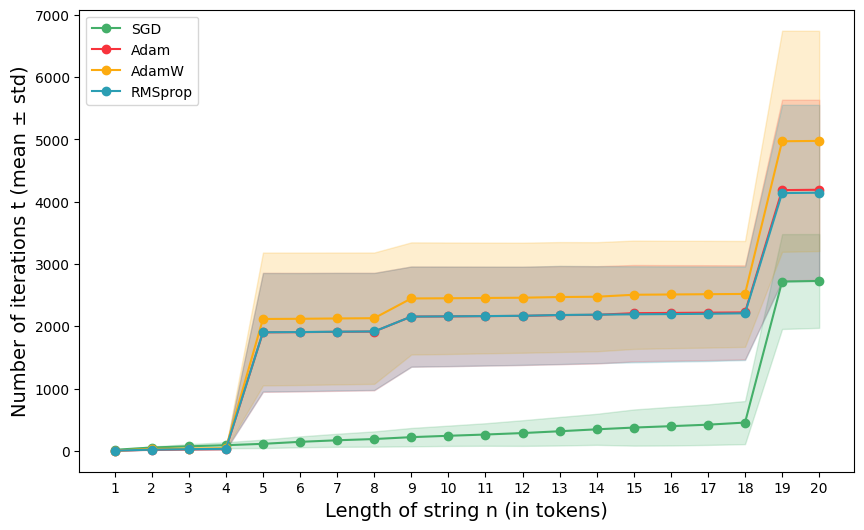

In [57]:
dataset_type = 'meaningful'
optimizers = ["SGD", "Adam", "AdamW", "RMSprop"]
layer = 4
learning_rates = 1

# filter dataframe based on dataset_type and optimizer
df_exp_8_2 = df[(df['dataset_type'] == dataset_type) & (df['layer'] == layer) & (df['learning_rate'] == learning_rates)]

df_exp_8_2_results = {
    x: compute_statistics(df_exp_8_2[df_exp_8_2['optimizer'] == x], indices=range(20), column_name='timesteps', agg = "sum")
    for x in optimizers
}
plot_metrics(
    metrics=df_exp_8_2_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
)

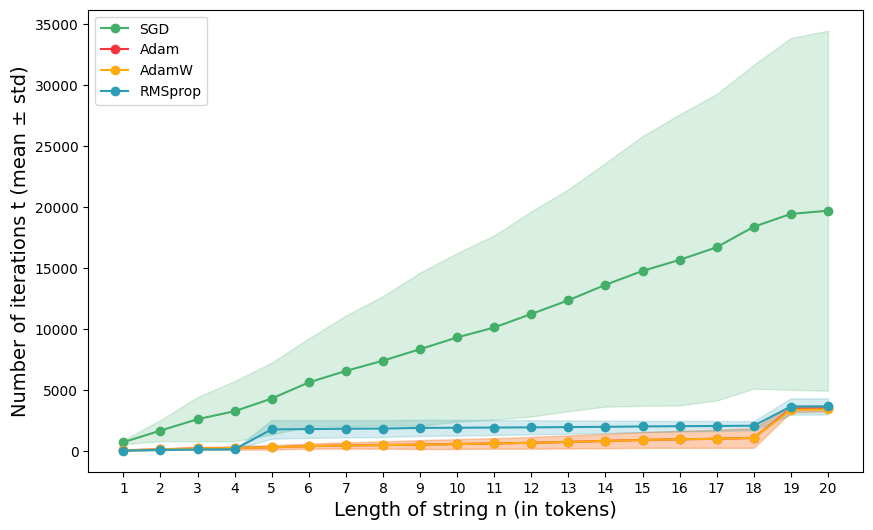

In [58]:
dataset_type = 'meaningful'
optimizers = ["SGD", "Adam", "AdamW", "RMSprop"]
layer = 4
learning_rates = 0.01

# filter dataframe based on dataset_type and optimizer
df_exp_8_2 = df[(df['dataset_type'] == dataset_type) & (df['layer'] == layer) & (df['learning_rate'] == learning_rates)]

df_exp_8_2_results = {
    x: compute_statistics(df_exp_8_2[df_exp_8_2['optimizer'] == x], indices=range(20), column_name='timesteps', agg = "sum")
    for x in optimizers
}
plot_metrics(
    metrics=df_exp_8_2_results,
    xlabel="Length of string n (in tokens)",
    ylabel="Number of iterations t (mean ± std)",
    title="", integer_xticks=True
)

In [66]:
df[df["optimizer"] == "baseline"].head()

,dataset,index,layer,learning_rate,optimizer,token_length,match,inversion_time,timesteps,times,dataset_type
0,token_length_filtered_dataset.csv,0,4,1.0,baseline,20,True,7351.385433,50186_49690_50002_45509_50231_50255_49435_5025...,462.85_464.30_462.34_327.61_365.61_364.28_359....,meaningful
1,token_length_filtered_dataset.csv,1,4,1.0,baseline,20,True,7207.425212,49444_42919_49247_48716_50035_49748_49667_3579...,346.65_310.42_353.58_351.17_360.46_357.48_358....,meaningful
2,token_length_filtered_dataset.csv,2,4,1.0,baseline,20,True,7010.390019,49444_46110_49721_44105_50252_46154_50158_5025...,346.88_341.27_370.00_327.72_375.28_325.92_358....,meaningful
3,token_length_filtered_dataset.csv,3,4,1.0,baseline,20,True,6437.304603,43629_49316_43527_28567_35850_50252_38917_5022...,307.57_361.12_321.58_212.35_267.12_366.40_284....,meaningful
4,token_length_filtered_dataset.csv,4,4,1.0,baseline,20,True,6708.775810,43629_35900_44442_47687_46399_50246_49861_4845...,308.26_268.29_332.94_355.57_340.97_374.30_365....,meaningful


SGD: (np.float64(1.21785), np.float64(2.1767613564141057)), Adam: (np.float64(1.7577000000000003), np.float64(3.6093860912287505)), AdamW: (np.float64(2.0645000000000002), np.float64(4.358278291558109)), RMSprop: (np.float64(1.7419499999999999), np.float64(3.549506322872395)), Baseline: (np.float64(307.684), np.float64(56.24257026191696))


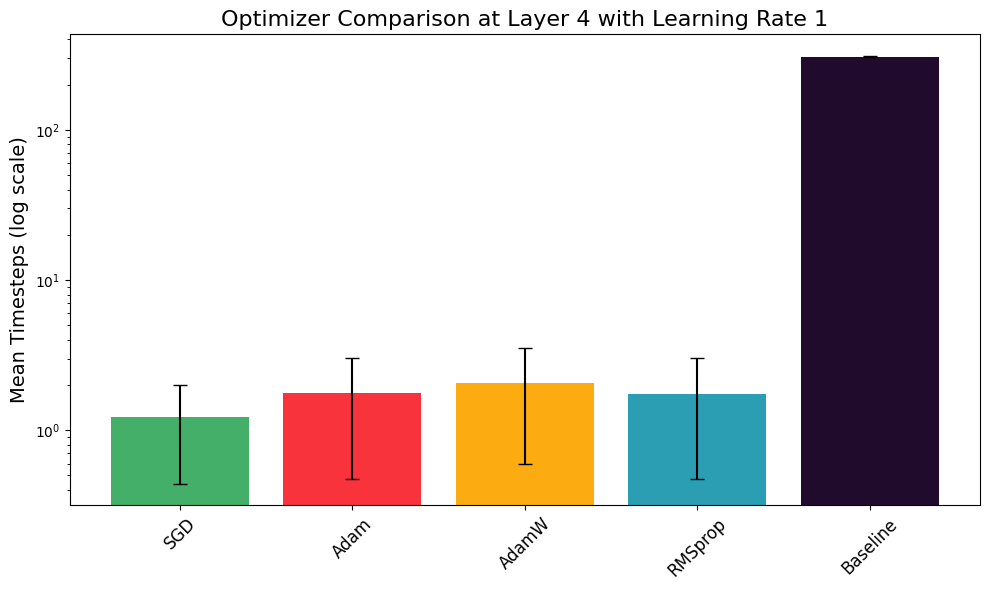

In [74]:
dataset_type = 'meaningful'
optimizers = ["SGD", "Adam", "AdamW", "RMSprop", "baseline"]
layer = 4
learning_rates = 1
df_exp_8_2 = df[(df['dataset_type'] == dataset_type) & (df['layer'] == layer) & (df['learning_rate'] == learning_rates)]
df_exp_8_2_results = {
    x: compute_statistics(df_exp_8_2[df_exp_8_2['optimizer'] == x], indices=range(20), column_name='times', agg = "mean")
    for x in optimizers
}
baseline = df_exp_8_2_results["baseline"][19] # mean, std
SGD = df_exp_8_2_results["SGD"][19] # mean, std
Adam = df_exp_8_2_results["Adam"][19] # mean, std
AdamW = df_exp_8_2_results["AdamW"][19] # mean, std
RMSprop = df_exp_8_2_results["RMSprop"][19] # mean, std
print(f"SGD: {SGD}, Adam: {Adam}, AdamW: {AdamW}, RMSprop: {RMSprop}, Baseline: {baseline}")

# represent them as a bar plot with names on the x-axis and mean values on the y-axis, with error bars for std

def plot_bar_with_error_bars_log(
    data: dict[str, tuple[np.float64, np.float64]],
    title: str = "Optimizer Comparison",
    ylabel: str = "Mean Timesteps"
) -> None:
    """
    Plots a bar chart of mean values with error bars (std), using a log y-axis.
    
    Args:
        data:   Mapping from label to (mean, std) tuple.
        title:  Title of the plot.
        ylabel: Label for the y-axis.
    """
    names = list(data.keys())
    means = [data[name][0] for name in names]
    stds  = [np.log(data[name][1]) for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(
        names,
        means,
        yerr=stds,
        capsize=5,
        color=COLORS[:len(names)]
    )
    plt.yscale('log')
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

plot_bar_with_error_bars_log(
    data={
        "SGD": SGD,
        "Adam": Adam,
        "AdamW": AdamW,
        "RMSprop": RMSprop,
        "Baseline": baseline
    },
    title="Optimizer Comparison at Layer 4 with Learning Rate 1",
    ylabel="Mean Timesteps (log scale)"
)

SGD: (np.float64(98.72999999999999), np.float64(174.02497617679288)), Adam: (np.float64(137.35999999999999), np.float64(281.8254126622051)), AdamW: (np.float64(160.41), np.float64(337.2187311918878)), RMSprop: (np.float64(136.72), np.float64(277.740403574593)), Baseline: (np.float64(45715.685), np.float64(2556.177531442212))


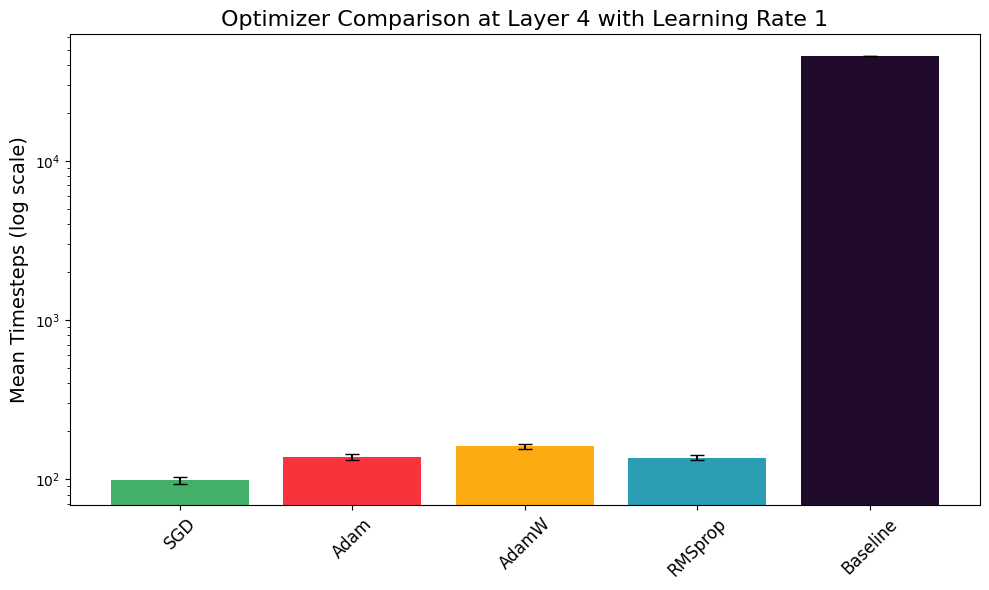

In [76]:
dataset_type = 'meaningful'
optimizers = ["SGD", "Adam", "AdamW", "RMSprop", "baseline"]
layer = 4
learning_rates = 1
df_exp_8_2 = df[(df['dataset_type'] == dataset_type) & (df['layer'] == layer) & (df['learning_rate'] == learning_rates)]
df_exp_8_2_results = {
    x: compute_statistics(df_exp_8_2[df_exp_8_2['optimizer'] == x], indices=range(20), column_name='timesteps', agg = "mean")
    for x in optimizers
}
baseline = df_exp_8_2_results["baseline"][19] # mean, std
SGD = df_exp_8_2_results["SGD"][19] # mean, std
Adam = df_exp_8_2_results["Adam"][19] # mean, std
AdamW = df_exp_8_2_results["AdamW"][19] # mean, std
RMSprop = df_exp_8_2_results["RMSprop"][19] # mean, std
print(f"SGD: {SGD}, Adam: {Adam}, AdamW: {AdamW}, RMSprop: {RMSprop}, Baseline: {baseline}")

# represent them as a bar plot with names on the x-axis and mean values on the y-axis, with error bars for std

def plot_bar_with_error_bars_log(
    data: dict[str, tuple[np.float64, np.float64]],
    title: str = "Optimizer Comparison",
    ylabel: str = "Mean Timesteps"
) -> None:
    """
    Plots a bar chart of mean values with error bars (std), using a log y-axis.
    
    Args:
        data:   Mapping from label to (mean, std) tuple.
        title:  Title of the plot.
        ylabel: Label for the y-axis.
    """
    names = list(data.keys())
    means = [data[name][0] for name in names]
    stds  = [np.log(data[name][1]) for name in names]

    plt.figure(figsize=(10, 6))
    plt.bar(
        names,
        means,
        yerr=stds,
        capsize=5,
        color=COLORS[:len(names)]
    )
    plt.yscale('log')
    plt.ylabel(ylabel, fontsize=14)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()
    plt.show()

plot_bar_with_error_bars_log(
    data={
        "SGD": SGD,
        "Adam": Adam,
        "AdamW": AdamW,
        "RMSprop": RMSprop,
        "Baseline": baseline
    },
    title="Optimizer Comparison at Layer 4 with Learning Rate 1",
    ylabel="Mean Timesteps (log scale)"
)